In [159]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
import math

from scipy.optimize import minimize 
from sklearn.metrics import mean_squared_error
from scipy.special import softmax


In [160]:
import tensorflow_datasets as tfds
from tensorflow import keras 
from keras import layers
from keras import backend as K

## MNIST Dataset

In [177]:
# Prepare the dataset. We use both the training & test MNIST digits.

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

print(np.shape(all_digits))

batch_size = 128

dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size = 1024).batch(batch_size)

(70000, 28, 28, 1)


## GAN

https://keras.io/guides/customizing_what_happens_in_fit/#wrapping-up-an-endtoend-gan-example

In [168]:
"""save weights"""
#gan.save_weights('/Users/andrewgoh/Desktop/ML_Projects/misc/gan_weights', overwrite=True, save_format=None, options=None)

'save weights'

In [169]:
"""load weights"""
#gan = GAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim)
'''gan.load_weights('/Users/andrewgoh/Desktop/ML_Projects/misc/gan_weights', by_name=False, skip_mismatch=False, options=None)
'''


"gan.load_weights('/Users/andrewgoh/Desktop/ML_Projects/misc/gan_weights', by_name=False, skip_mismatch=False, options=None)\n"

In [182]:
from keras import layers

# Create the discriminator
discriminator = keras.Sequential(
    [
        keras.Input(shape = (28, 28, 1)),
        layers.Conv2D(64, (3, 3), strides = (2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha = 0.2),

        layers.Conv2D(128, (3, 3), strides = (2, 2), padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        
        layers.GlobalMaxPooling2D(),
        layers.Dense(1, activation = 'softmax'),   
    ],
    name="discriminator",
)

discriminator.summary()

# Create the generator
latent_dim = 128
generator = keras.Sequential(
    [
        keras.Input(shape = (latent_dim,)),
        layers.Dense(7*7*128),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha = 0.2),
        layers.Reshape((7, 7, 128)),

        layers.Conv2DTranspose(128, (4, 4), strides = 2, padding = "same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha = 0.2),

        layers.Conv2DTranspose(128, (4, 4), strides = 2, padding = "same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha = 0.2),
        layers.Conv2D(1, (7, 7), padding = "same", activation = "sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_113 (Conv2D)         (None, 14, 14, 64)        640       
                                                                 
 batch_normalization_152 (Ba  (None, 14, 14, 64)       256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_145 (LeakyReLU)  (None, 14, 14, 64)       0         
                                                                 
 conv2d_114 (Conv2D)         (None, 7, 7, 128)         73856     
                                                                 
 batch_normalization_153 (Ba  (None, 7, 7, 128)        512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_146 (LeakyReLU)  (None, 7, 7, 128)      

In [183]:
# basic GAN architecture and training logic

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator 
        self.generator = generator
        self.latent_dim = latent_dim 
        self.d_loss_tracker = keras.metrics.Mean(name = 'd_loss')
        self.g_loss_tracker = keras.metrics.Mean(name = 'g_loss')

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn 
        self.g_loss_fn = g_loss_fn 

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        
        batch_size = tf.shape(real_images)[0]
        
        # sample vectors from latent space
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))
        
        # decode latent vector samples to 'fake' images
        generated_images = self.generator(random_latent_vectors)
        
        # concatenate with real images
        combined_images = tf.concat([generated_images, real_images], axis = 0)

        # implement labels, fake = 1, real = 0
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis = 0)

        # add noise to labels, helps stablize GAN during training, prevents mode collapse and overfitting
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # TRAIN THE DISCRIMINATOR

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.d_loss_fn(labels, predictions)
        
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # TRAIN THE GENERATOR 

        # new sample vectors from latent space
        random_latent_vectors = tf.random.normal(shape = (batch_size, self.latent_dim))

        # create misleading labels, we want the discriminator to classify the generator as real = 0
        misleading_labels = tf.zeros((batch_size, 1))

        # gradients 
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.g_loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # update state of trackers
        self.d_loss_tracker.update_state(d_loss)
        self.g_loss_tracker.update_state(g_loss)

        return {
            'd_loss': self.d_loss_tracker.result(),
            'g_loss': self.g_loss_tracker.result()
        }


In [185]:
# initialize GAN and compile

gan = GAN(discriminator = discriminator, generator = generator, latent_dim = latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    d_loss_fn=keras.losses.BinaryCrossentropy(),
    g_loss_fn=keras.losses.BinaryCrossentropy(),
)

In [188]:
epochs = 3

gan.fit(dataset, epochs = epochs)

Epoch 1/3
 78/547 [===>..........................] - ETA: 11:00 - d_loss: 0.2755 - g_loss: 2.0774

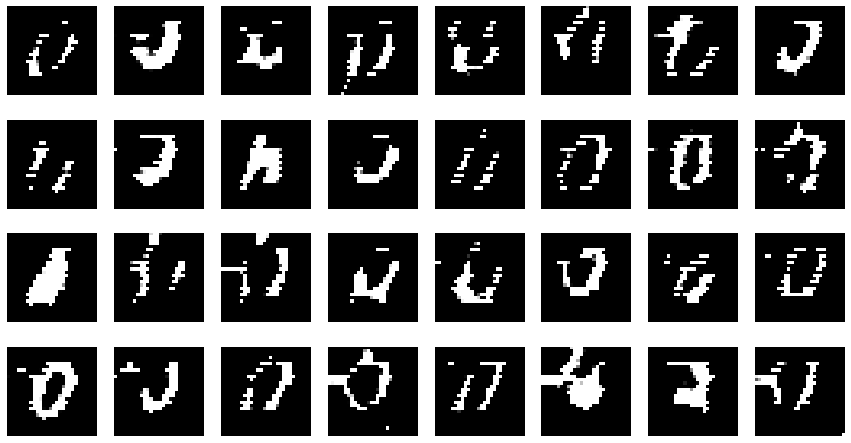

In [187]:
# generate random digits

scale = 1
length = 0

plt.figure(figsize=(15,8))
for i in range(32): 
  z = []
  for j in range(latent_dim):
    z.append(np.random.normal(loc = 0, scale = scale))

  ax = plt.subplot(4, 8, i + 1)
  z_vector_sampled = np.array([z])
  generated = generator.predict(z_vector_sampled, verbose = False)
  image = (generated[0].reshape(28,28)+1)/2
  plt.imshow(image, cmap = 'gray')
  plt.axis("off")